# **Environmental computing codes and software - Tutorial to train and run two competing hydrological models**
December 2024 - Toulouse INP/ENSEEIHT<br />
Supervised by Mohamed SAADI (Toulouse INP/ENSEEIHT \& [IMFT](https://www.imft.fr/en/accueil-english/); mohamed.saadi@toulouse-inp.fr) and Thomas BONOMETTI (Toulouse INP/ENSEEIHT \& IMFT; thomas.bonometti@toulouse-inp.fr)<br />

Last update: 2024-12-02

# **1. Introduction: Libraries, classes, and functions**

This notebook provides a script to train and test two models in order to evaluate their capacity in predicting daily discharge knowing the input catchment-scale precipitation and potential evapotranspiration. The two model structures consist of:
1. a deep-learning model based on Long Short-Term Memory networks (LSTM; [Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf)), which is composed of one layer of $128$ LSTM cells connected to an input layer of two cells (precipitation and potential evapotranspiration) and to a dense layer with $1$ neuron that outputs the discharge. This model is implemented using classes from the `PyTorch` library, which is a well-known machine-learning library originally developed by Meta AI (ex Facebook);
2. the GR4J (*Génie Rural à 4 paramètres au pas de temps Journalier*; [Perrin et al., 2003](https://www.sciencedirect.com/science/article/abs/pii/S0022169403002257)) daily conceptual model, which provides daily discharge using input precipitation and potential evapotranspiration at the daily time step. This model contains 4 catchment-scale parameters ($X_1~[\text{mm}]$, $X_2~[\text{mm}]$, $X_3~[\text{mm}]$, and $X_4~[\text{d}]$) that should be calibrated (or optimized).

For an introduction to LSTM, check [this video from the very helpful StatQuest YouTube channel](https://www.youtube.com/watch?v=YCzL96nL7j0), and [this paper by Kratzert et al. (2018)](https://hess.copernicus.org/articles/22/6005/2018/).

For a detailed presentation of GR4J, check [this paper by Perrin et al. (2003)](https://www.sciencedirect.com/science/article/abs/pii/S0022169403002257).

The objective of this work is to answer the following question: **On a set of several catchments, how does the LSTM compare to GR4J in terms of test performances and training cost?**

For both models, three phases are implemented: (1) preparation of data; (2) model training; and (3) model evaluation.

**For the LSTM model**, several classes and functions are used during the following stages of the implementation:
1. For data preparation, the `reshape_data()` function divides the input into series with a total length corresponding to the sequence length `seq_len`. This hyperparameter represents the number of previous time steps in the output data that are needed to predict the output. In our case, it should reflect the characteristic response time of the catchment. Hence, it should be carefully chosen or fine-tuned on the validation dataset. A default value of `seq_len = 365` is recommended, but the runtime is relatively long.

2. Once prepared, the training/validation/test datasets are incorporated within objects of the `MyDataset` class, which inherits from the `Dataset` class of the `PyTorch` library. `MyDataset` provides an efficient loading of data, especially randomly shuffled batches from the training dataset for gradient descent in the training phase.

3. The model's core architecture itself is presented using the `LSTM_model` class, which contains an `__init__()` method and a `forward()` method. The `forward()` method takes the input data and provides the output of the LSTM network.
4. The training is accomplished by calling the function `train_epoch()`, which needs 

    4.1. the model to be optimized (i.e., the LSTM),
    
    4.2. the optimizer, i.e. the gradient descent algorithm, which decides how the parameters should be updated depending on the gradient of the loss function. In our case, the [`adam`](https://optimization.cbe.cornell.edu/index.php?title=Adam) optimizer is used,
    
    4.3. the loss function (here Nash-Sutcliffe efficiency, or NSE). This one is defined as a class `loss_NSE` and uses the array type proper to `PyTorch`: `torch.Tensor`. This type is used because it enables efficient memory usage and stores the gradients computed using [the automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) implemented in `PyTorch`, and
    
    4.4. the `loader` of the training data.
    
5. During the training, an `EarlyStopping` class is used to stop the training when the errors on the validation dataset do not improve.

6. Finally, the function `eval_model()` is used to run the model without gradient backpropagation. This is especially used to provide model predictions for the validation and test periods.

**For the GR4J model**, and unlike LSTM, very limited data processing is needed. Nevertheless, several functions are also implemented:
1. The function `calibration_PAPGR()` trains (calibrates) the model on the calibration/training period. The training dataset is the same as the one used to train the LSTM. This function is a `Python`-like implementation of the calibration algorithm used in the `R` package [`airGR`](https://hydrogr.github.io/airGR/). It needs three supporting functions `transfo_param`, `NewCandidates`, `NewCandidatesLoc` to transform and create parameter sets, which are helpful to map the landscape of the loss function and look for an optimum. This calibration function needs a specification of:
    
    1.1. the model to be trained `run_model` and several other model-specified choices: the parameters that should be trained `msk_optim`, the constant values for the parameters that will not be trained `val_nonoptim`, and the starting parameter distribution `StartParamDistribT` which is provided by default for GR4J,
    
    1.2. the catchment dataset `data_cat` and the training time steps `msk_train`, and 
    
    1.3. the loss function `loss_func` and whether this loss function should be maximized or minimized.

2. The function `run_GR4J` which wrapps the core model class `ModelGr4j` implemented within the [`hydrogr`](https://github.com/SimonDelmas/hydrogr/blob/master/example/calibrating_gr4j.ipynb) library. This function provides simulated discharge from provided `inputs` and parameter set `parameters`.

In [1]:
## libraries
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from typing import Tuple, List
import os, re, time, sys
from tqdm.notebook import tqdm
from hydrogr import InputDataHandler, ModelGr4j
import spotpy

## ----------------- LSTM Functions ---------------
@njit ## to accelerate
def reshape_data(x, y, seq_length):
    """
    Reshape matrix data into sample shape for LSTM training.

    x: matrix containing time steps as rows and input features as columns
    y: matrix containing time steps as rows and output features as columns
    seq_length: lookback
    """
    num_samples, num_features = x.shape
    x_new = np.zeros((num_samples - seq_length + 1, seq_length, num_features), np.float64)
    y_new = np.zeros((num_samples - seq_length + 1, 1),np.float64)

    for i in range(0, x_new.shape[0]):
        x_new[i, :, :num_features] = x[i:i + seq_length, :]
        y_new[i, :] = y[i + seq_length - 1, 0]

    return x_new, y_new

## MyDataset: PyTorch class for easy loading of data
class MyDataset(Dataset):
    def __init__(self, x_in, y_out):
        self.x_data = torch.from_numpy(x_in.astype(np.float32))
        self.y_data = torch.from_numpy(y_out.astype(np.float32))
        self.len = x_in.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

## LSTM model class
class LSTM_model(nn.Module):
    """Implementation of an LSTM network with ONE single layer + a dense layer
    """
    
    ## we need the __init__() method for inheritance from the nn.Module class
    def __init__(self, hidden_size, num_features, dropout_rate, nblayers):
        """create the model with user-defined hyperparameters
        hidden_size : number of LSTM cells
        num_features: number of input features
        dropout_rate: rate for regularization
        nb_layers   : number of LSTM layers
        """
        super().__init__()
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.num_features = num_features
        self.nblayers = nblayers

        ## create the LSTM
        self.lstm = nn.LSTM(input_size = self.num_features, hidden_size = self.hidden_size, 
                            num_layers = self.nblayers, bias = True, batch_first = True)
        
        ## add a dropout layer
        self.dropout = nn.Dropout(p = self.dropout_rate)
        
        ## linear layer at the head
        self.fc = nn.Linear(in_features = self.hidden_size, out_features = 1)
    
    ## we need the forward method to run a prediction
    def forward(self, x):
        """forward the data through the network.
        x: input (torch.Tensor)
        """
        output, (h_n, c_n) = self.lstm(x)

        # perform prediction only at the end of the input sequence
        pred = self.fc(self.dropout(h_n[-1,:,:]))
        return pred


## function for training
def train_epoch(model, optimizer, train_loader, loss_func, epoch, device):
    """train model for a single epoch.
    model          : a torch.nn.Module implementing the LSTM model
    optimizer      : one of PyTorchs optimizer classes.
    train_loader   : a PyTorch DataLoader, providing the trainings
                     data in mini batches.
    loss_func      : the loss function to minimize.
    epoch          : the current epoch (int) used for the progress bar
    """
    ## set model to train mode (important for dropout)
    model.train()
    ## request mini-batch of data from the loader
    for x_, y_ in train_loader:
        ## delete previously stored gradients from the model
        optimizer.zero_grad()
        ## push data to GPU (if available)
        x_, y_ = x_.to(device), y_.to(device)
        ## get model predictions
        y_sim = model(x_)
        ## calculate loss
        loss = loss_func(y_sim, y_)
        ## calculate gradients
        loss.backward()
        ## update the weights
        optimizer.step()
    return loss.item()

## function to evaluate the model
def eval_model(model, dataloader, device):
    """Evaluate the model.
    model     : a torch.nn.Module implementing the LSTM model
    dataloader: pytorch dataloader
    """
    ## set the model to evaluation mode (important for dropout)
    model.eval()
    obs = []
    preds = []
    
    ## no backpropagation
    with torch.no_grad():
        # request mini-batch of data from the loader
        for x_, y_ in dataloader:
            ## push data to GPU (if available)
            x_ = x_.to(device)
            ## get model predictions
            y_sim = model(x_)
            obs.append(y_)
            preds.append(y_sim)
    return torch.cat(obs), torch.cat(preds)

## an EarlyStopper class
class EarlyStopper:
    ''' This class stops the training based on the evolution of the validation loss'''
    def __init__(self, patience = 1, min_delta = 0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss + self.min_delta < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


## ----------------- GR Functions ---------------
## transformation of parameters for GR4J
def transfo_param(params_in, dir_ = "R_to_T"):
    ''' transform parameters for efficient sampling of the loss function'''
    params_out = params_in.copy()
    if dir_ == "T_to_R":
        params_out[:,0] = np.exp(params_in[:,0])
        params_out[:,1] = np.sinh(params_in[:,1])
        params_out[:,2] = np.exp(params_in[:,2])
        params_out[:,3] = 20. + 19.5*(params_in[:,3] - 9.99)/19.98
    
    if dir_ == "R_to_T":
        params_out[:,0] = np.log(params_in[:,0])
        params_out[:,1] = np.arcsinh(params_in[:,1])
        params_out[:,2] = np.log(params_in[:,2])
        params_out[:,3] = 9.99 + 19.98*(params_in[:,3] - 20.)/19.5
    return params_out

## function to propose new candidates of parameter sets from a distribution (Latin Hypercube)
def NewCandidates(distribParam):
    '''provides candidates of parameter from a distribution of parameter values'''
    #x1, x2, x3, x4 = np.meshgrid(params_in[:,0], params_in[:,1], params_in[:,2], params_in[:,3])
    #new_array = np.array([x1.flatten(), x2.flatten(), x3.flatten(), x4.flatten()])
    new_array = np.array([y.flatten() for y in np.meshgrid(*[x for x in distribParam.T])])
    return np.unique(new_array.T, axis = 0)

## function to propose new candidates of parameter sets in the vicinity of a parameter set
def NewCandidatesLocal(new_param, search_ranges, msk_optim, pace):
    '''local sampling in all directions in the vicinity of a parameter set'''
    if(new_param.shape[0] != 1):
        print("You should send only one parameter set to this function.\n") 
        sys.exit(1)
    nparam = new_param.shape[1]
    vector_params = np.ones((2*nparam,nparam))*np.nan
    i_r = 0
    for i in np.arange(nparam):
        #print(i)
        if msk_optim[i]:
            for sgn in [-1.,+1.]:
                potential_param = new_param.copy()
                potential_param[0, i] = new_param[0,i] + sgn*pace
                potential_param[0, :] = np.where(potential_param[0, :] < search_ranges[0, :], search_ranges[0, :], potential_param[0, :])
                potential_param[0, :] = np.where(potential_param[0, :] > search_ranges[1, :], search_ranges[1, :], potential_param[0, :])
                vector_params[i_r,:] = potential_param
                i_r += 1
    sum_param = np.sum(vector_params, axis = 1)
    vector_params_ = vector_params[np.isnan(sum_param) == False, :]
    return np.unique(vector_params_, axis = 0)

## function to optimize GR4J (~Calibration_Michel in airGR)
def calibration_PAPGR(run_model, msk_optim, val_nonoptim, StartParamDistribT, data_cat, 
                      msk_train, loss_func, maximize = True):
    ## parameters of the algorithm
    nparams = msk_optim.size
    pace = 0.64
    pacediag = np.zeros((1,nparams))
    CLG = 0.7**(1/nparams)
    Compt = 0
    nruns = 0
    HistParamR = np.ones((101*nparams,nparams))*np.nan
    HistParamT = HistParamR.copy()
    HistCrit   = np.ones((101*nparams,1))*np.nan
    critOpt    = -np.inf if maximize else np.inf
    multip     = 1 if maximize else -1

    ## parameter distributions
    StartParamDistribR = transfo_param(StartParamDistribT, "T_to_R")

    SearchRgT = np.array([np.ones(nparams)*-9.99, np.ones(nparams)*9.99])
    SearchRgR = transfo_param(SearchRgT, "T_to_R")

    ## opt out for non-optimized parameters
    StartParamDistribR[:, msk_optim == False] = np.inf
    CandidatParamR_list = NewCandidates(StartParamDistribR)
    for i_ in np.argwhere(msk_optim == False):
        CandidatParamR_list[:, i_] = val_nonoptim[i_]

    ## --- 1/2 grid search
    for iNew in np.arange(len(CandidatParamR_list)):
        Param_ = CandidatParamR_list[None, iNew,:]
        sim_ = run_model(Param_, data_cat)
        nruns += 1
        crit_ = loss_func(obs = data_cat.flow_mm.values[msk_train], sim = sim_[msk_train])
        if crit_*multip > critOpt*multip:
            iNewOpt = iNew
            critOpt = crit_
    print(f"End of global search | {nruns} runs, obj. function = {critOpt:.4f}")

    ## --- 2/2 starting the gradient descent
    new_param_R = CandidatParamR_list[None, iNewOpt,:]
    new_param_T = transfo_param(new_param_R, "R_to_T")
    old_param_T = new_param_T.copy()
    HistParamR[0,:] = new_param_R
    HistParamT[0,:] = new_param_T
    HistCrit[0,:] = critOpt
    iter_ = 1
    while iter_ < HistParamR.shape[0]:
        ## pace too small: exit the loop
        if pace < 0.01:
            break

        ## create new parameter sets by local descent
        CandidatParamT_list = NewCandidatesLocal(new_param_T, SearchRgT, msk_optim, pace)
        CandidatParamR_list = transfo_param(CandidatParamT_list, "T_to_R")
        Progress = False

        ## loop over the new parameter candidates in the vicinity of new_param
        for iNew in np.arange(CandidatParamR_list.shape[0]):
            Param_ = CandidatParamR_list[None, iNew,:]
            sim_ = run_model(Param_, data_cat)
            nruns += 1
            crit_ = loss_func(obs = data_cat.flow_mm.values[msk_train], sim = sim_[msk_train])
            if crit_*multip > critOpt*multip:
                Progress = True
                iNewOpt = iNew
                critOpt = crit_

        ## if there is progress: increase the pace
        if Progress:
            old_param_T = new_param_T.copy()
            new_param_T = CandidatParamT_list[None, iNewOpt, :]
            Compt += 1
            if Compt > 2*nparams:
                pace = pace * 2
                Compt = 0
            vect_pace = new_param_T - old_param_T
            pacediag = np.where(msk_optim == False, pacediag, CLG * pacediag + (1-CLG) * vect_pace)
        ## no progress: decrease the pace
        else:
            pace = pace/2
            Compt = 0

        ## diagonal screening
        if iter_ > 4*nparams:
            CandidatParamT = new_param_T + pacediag
            CandidatParamT = np.where(CandidatParamT < SearchRgT[0,:], SearchRgT[0,:], CandidatParamT)
            CandidatParamT = np.where(CandidatParamT > SearchRgT[1,:], SearchRgT[1,:], CandidatParamT)
            CandidatParamR = transfo_param(CandidatParamT, "T_to_R")
            #print(CandidatParamR.shape)
            Param_ = CandidatParamR[None, 0,:]
            sim_ = run_model(Param_, data_cat)
            nruns += 1
            crit_ = loss_func(obs = data_cat.flow_mm.values[msk_train], sim = sim_[msk_train])
            if crit_*multip > critOpt*multip:
                critOpt = crit_
                old_param_T = new_param_T.copy()
                new_param_T = CandidatParamT.copy()

        ## save the results of the screening
        new_param_R = transfo_param(new_param_T, "T_to_R")
        HistParamR[iter_,:] = new_param_R
        HistParamT[iter_,:] = new_param_T
        HistCrit[iter_,:]   = critOpt
        iter_ += 1

    paramFinalR = new_param_R
    paramFinalT = new_param_T
    crit_final   = critOpt
    print(f"End of local search | {iter_ - 1} iterations, {nruns} runs, obj. function = {crit_final:.4f}")
    return paramFinalR, crit_final

## run GR4J
def run_GR4J(parameters, inputs):
    '''run the GR4J model'''
    if parameters.size != 4:
        print("There should be four parameters to run GR4J.\n") 
        sys.exit(1)
    parameters = {"X1": parameters[0,0], "X2": parameters[0,1], "X3": parameters[0,2], "X4": parameters[0,3]}
    model = ModelGr4j(parameters)
    model.set_parameters(parameters)
    outputs = model.run(data_cat)
    return outputs["flow"].values

## ----------- Loss functions: one under pytorch and the equivalent for GR4J

## for LSTM
class loss_NSE(nn.Module):
    def __init__(self):
        super().__init__()  
    def forward(self, output, target):
        obs = target
        preds = output
        sum_errors = torch.sum( (obs - preds) **2)
        obs_m = torch.mean(obs)
        sum_vars = torch.sum( (obs - obs_m)**2 )
        return 1.-sum_errors/sum_vars
    
## for GR4J
def NSE(obs, sim):
    obs_m = np.mean(obs)
    N = np.sum((obs - sim)**2)
    D = np.sum((obs - obs_m)**2)
    return 1. - N/D

## for GR4J
def RMSE(obs, sim):
    return np.sqrt(np.mean((obs - sim)**2))

def MAE(obs, preds):
    return np.mean(np.abs(obs-preds))

# **2. Reading and preprocessing of the data for LSTM**

In this part, time series are loaded from the data folder and processed as to obtain inputs in the convenient format for the LSTM network.

**Tasks**. Make a loop over the provided catchments. Compute some statistics (means, max and min values) on the three features to characterize the catchments. 

In [3]:
## getting the data repo and the list of files
dir_proj = re.sub("\\\\","/", os.getcwd())
dir_data = f"{dir_proj}/data"
ts_files = os.listdir(dir_data)
ts_files = [file for file in ts_files if file.endswith(".csv")]

## choose one catchment
file_cat = ts_files[-1]
print(file_cat)

## Create stat df
catchment_stats = []
for file in ts_files:
    ## read the data
    data_cat = pd.read_csv(f"{dir_data}/{file}", sep = ";")
    data_cat.columns = ['date', 'precipitation', 'evapotranspiration', 'flow_mm']
    
    ## convert in terms of datatype
    data_cat.index = pd.to_datetime(data_cat.date)

    ## choices for the input data
    input_feat = ["precipitation", "evapotranspiration"]
    output_feat = ["flow_mm"]
    
    # Compute statistics for each features[0]
    features = ['precipitation', 'evapotranspiration', 'flow_mm']
    stats = {
        'Catchment': file,
        f'Mean_{features[0][:3]}': data_cat[features[0]].mean(),
        f'Max_{features[0][:3]}': data_cat[features[0]].max(),
        f'Min_{features[0][:3]}': data_cat[features[0]].min(),
        f'Mean_{features[1][:3]}': data_cat[features[1]].mean(),
        f'Max_{features[1][:3]}': data_cat[features[1]].max(),
        f'Min_{features[1][:3]}': data_cat[features[1]].min(),
        f'Mean_{features[2][:3]}': data_cat[features[2]].mean(),
        f'Max_{features[2][:3]}': data_cat[features[2]].max(),
        f'Min_{features[2][:3]}': data_cat[features[2]].min(),
    }
    catchment_stats.append(stats)

# Convert the list of statistics to a DataFrame
catchment_stats_df = pd.DataFrame(catchment_stats)

catchment_stats_df.head()  


Y5312010_tsdaily.csv


,Catchment,Mean_pre,Max_pre,Min_pre,Mean_eva,Max_eva,Min_eva,Mean_flo,Max_flo,Min_flo
0,A1072010_tsdaily.csv,2.521649,60.446,0.0,1.843731,5.434,0.0,0.736068,17.284,0.032
1,A3301010_tsdaily.csv,2.339075,61.726,0.0,1.829243,5.551,0.0,0.727154,10.200,0.248
2,A7010610_tsdaily.csv,2.963488,69.408,0.0,1.765607,5.453,0.0,1.380948,16.868,0.179
3,A9612010_tsdaily.csv,2.253005,53.989,0.0,1.788991,5.468,0.0,0.713863,18.570,0.155
4,B2130010_tsdaily.csv,2.602261,66.165,0.0,1.758833,5.336,0.0,0.855719,16.989,0.012


In [4]:
data_cat.head()


,date,precipitation,evapotranspiration,flow_mm
date,,,,
1997-01-01,1997-01-01,0.822,0.467,1.598
1997-01-02,1997-01-02,39.442,0.568,1.745
1997-01-03,1997-01-03,32.511,0.616,4.817
1997-01-04,1997-01-04,12.442,0.398,5.449
1997-01-05,1997-01-05,0.019,0.355,3.514


To prepare the data for the LSTM network:

**(1)** the lookback (or sequence length) `seq_len` should be specified so that the input data can be reshaped accordingly: 

In [5]:
## sequence length (in days)
seq_len = 30

## reshaping the data given the sequence length
x_in  = np.array(data_cat.drop([*output_feat, "date"], axis = 1))
y_out = np.array(data_cat[output_feat])
print("shape of x_in:", x_in.shape)
print("shape of y_out:", y_out.shape)

## reshaping
x_rshp, y_rshp = reshape_data(x = x_in, y = y_out, seq_length = seq_len)
date_rshp = data_cat.date[(seq_len-1):].values

print("shape of reshaped input:", x_rshp.shape)
print("shape of reshaped output:", y_rshp.shape)
print("shape of the dates:", date_rshp.shape)


shape of x_in: (5844, 2)
shape of y_out: (5844, 1)
shape of reshaped input: (5815, 30, 2)
shape of reshaped output: (5815, 1)
shape of the dates: (5815,)


**(2)** the `nan` values should be removed:

In [6]:
## removing the cases with nan values in the output
## for this case, we are SURE there are no nan values in the input --> to be adapted for general cases
y_nan  = np.where(np.isnan(y_rshp), 1, 0)
y_nan_ = np.sum(y_nan, axis= 1)

date_rshp_, x_rshp_, y_rshp_ = date_rshp[y_nan_ == 0], x_rshp[y_nan_ == 0,:], y_rshp[y_nan_ == 0,:]
print("shape of reshaped input--no nan values:", x_rshp_.shape)
print("shape of reshaped output--no nan values:", y_rshp_.shape)
print("shape of the dates--no nan values:", date_rshp_.shape)


shape of reshaped input--no nan values: (5757, 30, 2)
shape of reshaped output--no nan values: (5757, 1)
shape of the dates--no nan values: (5757,)


**(3)** the training, validation, and test datasets should be specified:

In [7]:
## create the training, validation, and test datasets
## training, validation, and test proportions
tr_p, val_p, test_p = 0.5, 0.2, 0.3
n_samples = date_rshp_.size
tr_smpl = int(tr_p*n_samples)
tr_val_smpl = int((tr_p+val_p)*n_samples)

## split of the data
date_train, x_train, y_train = date_rshp_[:tr_smpl], x_rshp_[:tr_smpl, :], y_rshp_[:tr_smpl,:]
date_val  , x_val  , y_val   = date_rshp_[tr_smpl:tr_val_smpl], x_rshp_[tr_smpl:tr_val_smpl, :], y_rshp_[tr_smpl:tr_val_smpl,...]
date_test , x_test , y_test  = date_rshp_[tr_val_smpl:], x_rshp_[tr_val_smpl:, ...], y_rshp_[tr_val_smpl:,...]

print("shape of x_train and y_train:", x_train.shape, y_train.shape)
print("shape of x_val and y_val    :", x_val.shape, y_val.shape)
print("shape of x_test and y_test  :", x_test.shape, y_test.shape)
print("shape of date_rshp_         :", date_train.shape, date_val.shape, date_test.shape)

shape of x_train and y_train: (2878, 30, 2) (2878, 1)
shape of x_val and y_val    : (1151, 30, 2) (1151, 1)
shape of x_test and y_test  : (1728, 30, 2) (1728, 1)
shape of date_rshp_         : (2878,) (1151,) (1728,)


**(4)** finally, the input features should be standardized using mean and standard deviation computed on the training dataset (to avoid data leakage).

In [8]:
## standardization of the input data
x_mean = np.array(data_cat[data_cat.date.isin(date_train)][input_feat].mean())
x_std  = np.array(data_cat[data_cat.date.isin(date_train)][input_feat].std())
x_mean_r = x_mean.reshape((1, x_mean.shape[0]))
x_std_r  = x_std.reshape((1,x_std.shape[0]))

x_train = (x_train - x_mean_r)/x_std_r
x_val   = (x_val   - x_mean_r)/x_std_r
x_test  = (x_test  - x_mean_r)/x_std_r

# **3. LSTM: Model training**

Two sets of hyperparameters should be specified:

1. The hyperparameters of the network structure: the number of layers `num_layers = 1`, the number of LSTM cells `hidden_size = 128`, and the number of features `num_feat = 2` (precipitation and potential evapotranspiration); and

2. The hyperparameters of the network training: the max number of epochs `n_epochs = 2000`, the batch size `batch_size = 256`, the learning rate `lr = 0.001`, the dropout rate `dropout = 0.4`, and the `patience = 100` and the `min_delta = 0.0001` parameters of the early stopper.

**Tasks**. Look for the significance of each hyperparameter.

In [32]:
## device: cpu or cuda_gpu if availabled
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)

## hyperparameters for the model structure: 
##    number of layers, cells per layers, and number of input features
num_layers  = 1
hidden_size = 128
num_feat    = len(input_feat)

## training hyperparameters: batch size, max number of epochs, learning rate, optimizer and loss function
batch_size = 128
n_epochs   = 2000
lr         = 0.001
dropout    = 0.4
patience   = 100
min_delta  = 0.0001

using device: cpu


The datasets are then incorporated within `DataLoader` objects for easy loading. These need a specification of the `batch_size`.

In [33]:
## create DataLoaders for efficient loading of data (proper to pytorch)
ds_train = MyDataset(x_in = x_train, y_out = y_train)
ds_val   = MyDataset(x_in = x_val,   y_out = y_val)
ds_test  = MyDataset(x_in = x_test,  y_out = y_test)

train_Loader = DataLoader(ds_train, batch_size = batch_size, shuffle = True) 
val_Loader   = DataLoader(ds_val,   batch_size = batch_size, shuffle = False)
test_Loader  = DataLoader(ds_test,  batch_size = batch_size, shuffle = False)

An LSTM model object is created as an instance of the `LSTM_model` class using the structure hyperparameters. The loss function and the optimizers are also declared.

**Tasks**. Explain the sizes of the LSTM model parameters. What would be the total number of parameters for an LSTM cell with `hidden_size = 256`?

In [34]:
## model instantiation, loss function, and optimizer
mymodel = LSTM_model(hidden_size = hidden_size, num_features = num_feat, 
                         dropout_rate = dropout, nblayers = num_layers).to(device)
#loss_func = nn.MSELoss()
loss_func = loss_NSE()
optimizer = torch.optim.Adam(mymodel.parameters(), lr = lr, maximize = True)


## get an idea about the number of parameters in the model and their shapes
(wi, wh, bi, bh) = mymodel.lstm.parameters()
(wo, bo) = mymodel.fc.parameters()
print(wi.shape)
print(wh.shape)
print(bi.shape)
print(bh.shape)
print(wo.shape)
print(bo.shape)

torch.Size([512, 2])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([1, 128])
torch.Size([1])


Now, we are ready to train the model!

Note that the validation loss function is chosen to be different from the training loss function.

In [ ]:
## early stopper
early_stopper = EarlyStopper(patience = patience, min_delta = min_delta)

## model training
mypbar = tqdm(np.arange(n_epochs), position=0, leave=True)
val_mse_list = []
start_time = time.time()
for i_epoch in mypbar:
    train_loss   = train_epoch(mymodel, optimizer, train_Loader, loss_func, i_epoch+1, device)
    obs_, preds_ = eval_model(mymodel, train_Loader, device)
    train_loss_  = loss_func(obs_, preds_).item()
    obs_, preds_ = eval_model(mymodel, val_Loader, device)
    val_mse      = np.mean((obs_.numpy().flatten() - preds_.numpy().flatten())**2)
    val_mse_list.append(val_mse)
    stop_ = early_stopper.early_stop(val_mse)
    mypbar.set_description(f'Training loss: {train_loss_:.3f} | Validation error: {val_mse:.4f} | Counter: {early_stopper.counter} | Progress')
    if stop_:
        print('Done! Early stop at epoch', i_epoch)
        break
print("--- %s minutes ---" % str(round((time.time() - start_time)/60,2)))

  0%|          | 0/2000 [00:00<?, ?it/s]

# **4. GR4J: Model calibration**

For the python implementation of GR models, see [the `hydrogr` `Python` library](https://pypi.org/project/hydrogr/). The following code lines were taken from the package tutorial example [provided here for running a model](https://github.com/SimonDelmas/hydrogr/blob/master/example/gr4j.ipynb). To calibrate the GR4J model, the calibration (or training) begin/end time steps should be specified. **These should be coherent with the training/test periods for LSTM.**

In [30]:
## date train and test
beg_train = np.min(date_train)
print(beg_train)
beg_train = "1998-01-01"
end_train = np.max(date_train)
print(end_train)
end_train = "2008-12-14"
beg_test = np.min(date_test)
end_test = np.max(date_test)


## mask for training and test periods (removes the nan values)
nan_msk   = np.where(np.isnan(data_cat.flow_mm.values), False, True)
msk_train = (data_cat.index.values >= pd.to_datetime(beg_train))*(data_cat.index.values <= pd.to_datetime(end_train))*nan_msk
msk_test  = (data_cat.index.values >= pd.to_datetime(beg_test))*(data_cat.index.values <= pd.to_datetime(end_test))*nan_msk
print(sum(msk_train))
print(sum(msk_test))

1997-01-30
2004-12-16
3945
1728


Now, we can train the GR4J model!

In [31]:
## calibration: which model, which parameters to calibrate, starting parameter distribution
run_model    = run_GR4J
msk_optim    = np.array([True, True, True, True])
val_nonoptim = np.ones(4)*np.nan
StartParamDistribT = np.array([[5.13, -1.60, 3.03, -9.05],
                            [5.51, -0.61, 3.74, -8.51],
                            [6.07, -0.02, 4.42, -8.06]])
## calibration: cost function and 
loss_func_gr = RMSE
maximize     = False

## running the calibration
start_time = time.time()
param_final, crit_final = calibration_PAPGR(run_model = run_model, msk_optim = msk_optim, 
                                            val_nonoptim = val_nonoptim, StartParamDistribT = StartParamDistribT, 
                                            data_cat = data_cat, msk_train = msk_train, 
                                            loss_func = loss_func_gr, maximize = maximize)
print("--- %s secondes ---" % str(round((time.time() - start_time),4)))
# print(crit_final)
# print(param_final)

End of global search | 81 runs, obj. function = 0.3828
End of local search | 24 iterations, 281 runs, obj. function = 0.3283
--- 1.2918 secondes ---


In [ ]:
## Store dataframe

# **5. GR4J vs. LSTM: Model evaluation**

Finally, the optimized LSTM model and the GR4J model with the best parameter set `param_final` are used to make predictions on the unseen, test dataset.

**Tasks**. Design test metrics that focus on specific parts of the simulations (for example, peak flows, low flows). Expand the methodology to handle several catchments and plot a distribution of performances for both models. Are the conclusions similar if we train the models on the most recent period and test them on the earliest period? What if we choose to train the models on other scores, like the Kling-Gupta Efficiency (or KGE)?

In [36]:
## get the test predictions for both models
obs_t, preds_lstm = eval_model(mymodel, test_Loader, device)
obs_t, preds_lstm = obs_t.numpy().flatten(), preds_lstm.numpy().flatten()

sim_ = run_model(param_final, data_cat)
preds_gr = sim_[msk_test]

## NSE in test + MAE (mm/d)
nse_t_lstm = NSE(obs_t, preds_lstm)
nse_t_gr   = NSE(obs_t, preds_gr)
mae_t_lstm = MAE(obs_t, preds_lstm)
mae_t_gr   = MAE(obs_t, preds_gr)

print(f"LSTM - NSE: {nse_t_lstm:.3f}, MAE (mm/d): {mae_t_lstm:.3f}")
print(f"GR4J - NSE: {nse_t_gr:.3f}, MAE (mm/d): {mae_t_gr:.3f}")

LSTM - NSE: 0.478, MAE (mm/d): 0.413
GR4J - NSE: 0.883, MAE (mm/d): 0.244


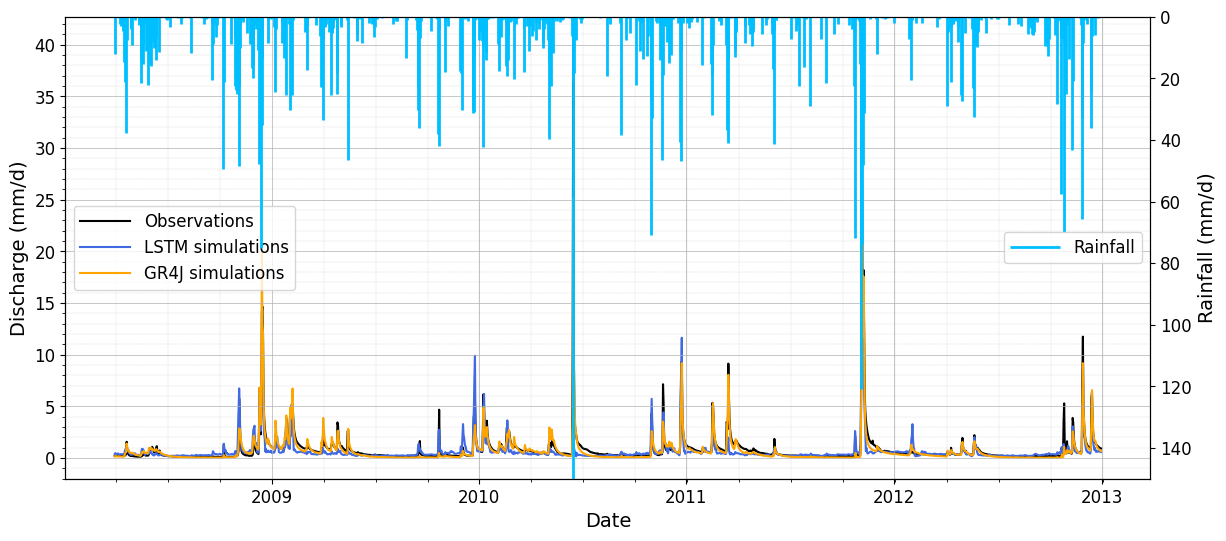

In [37]:
## init of figures
def inifig(xdim,ydim):
    fig = plt.figure(figsize=(xdim,ydim))
    ax = plt.subplot(1,1,1)
    ax.clear()
    ax.grid(which='minor', color='grey', linestyle='-.', linewidth = 0.1)
    ax.grid(which = "major", linewidth = 0.5)
    ax.minorticks_on()
    ax.tick_params(axis = "y", labelsize = 12)
    ax.tick_params(axis = "x", labelsize = 12)
    return fig, ax

## plotting
figh, axh = inifig(14,6)
axh.plot(np.array(pd.to_datetime(date_test)), obs_t, color='black', linestyle='solid', 
         linewidth = 1.5, zorder = 0, label = "Observations")
axh.plot(np.array(pd.to_datetime(date_test)), preds_lstm,color='royalblue', linestyle='solid',
         linewidth = 1.5, zorder = 1, label = "LSTM simulations")
axh.plot(np.array(pd.to_datetime(date_test)), preds_gr,color='orange', linestyle='solid',
         linewidth = 1.5, zorder = 1, label = "GR4J simulations")

axh.set_xlabel("Date", fontsize = 14)
axh.set_ylabel("Discharge (mm/d)", fontsize = 14)
ax_ = axh.twinx()
zero_precip_msk   = np.where(data_cat.precipitation > 0, True, False)
msk_test_precip  = (data_cat.index.values >= pd.to_datetime(beg_test))*(data_cat.index.values <= pd.to_datetime(end_test))*zero_precip_msk
ax_.vlines(data_cat.index.values[msk_test_precip], ymin = 0, ymax = data_cat.precipitation.values[msk_test_precip],
           color='deepskyblue', label = "Rainfall", linewidth = 2.)
ax_.set_ylim(0, 150)
ax_.invert_yaxis()
ax_.set_ylabel('Rainfall (mm/d)', fontsize = 14)
ax_.tick_params(axis = "y", labelsize = 12)
axh.legend(loc = "center left", handlelength = 3, fontsize = 12)
ax_.legend(loc = "center right", handlelength = 3, fontsize = 12)
plt.show()